In [18]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.special import erf
import scipy.integrate as integrate

import math
import pickle

import Lava as Lava
sys.path.append('/home/iganesh/pvert')
# sys.path.append('/home/indujaa/Projects/pvert')
from FresnelCoefficients import FresnelH, FresnelV

### <b> Comparison of upper surface cooling and crustal growth between Earth and Venus </b>

In [10]:
## read in data from Flynn and Mouginins-Mark 1992
# data = pd.read_csv("FlynnMougnisMark_Puuoo.csv")

# t_data = data.Seconds.to_numpy()
# T_data = data.Tc.to_numpy()

In [11]:
data = pd.read_csv("Hon1994_lavaflow_surfT_17Apr1990.csv")
t_Hon = data.Seconds
Ts_Hon = data.Temp_K

In [16]:
Tlava = 1135 + 273
Ta_venus = 737 
Ta_earth = 30 + 273
Tsub_venus = Ta_venus
Tsub_earth = Ta_earth

## Thermal parameters
L = 100e3                    ## latent heat capacity in J/kg; value from Wittmann et al.2017
c =  1200                    ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 1                        ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
rho = 2600                   ## Basalt density from Davies et al., 2006
kappa = k/rho/c              ## thermal diffusivity in m2/s;

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

In [17]:
## Earth
Trange = np.arange(Tlava, Ta_earth, -5)

trange_earth = np.zeros_like(Trange, dtype = np.float32)
trange_venus_noconv = np.zeros((2, len(Trange)), dtype = np.float32)
trange_venus_snyder = np.zeros_like(Trange, dtype = np.float32)

upper_crust_earth = np.zeros_like(Trange, dtype = np.float32)
upper_crust_venus_noconv = np.zeros((2, len(Trange)), dtype = np.float32)
upper_crust_venus_snyder = np.zeros_like(Trange, dtype = np.float32)

In [23]:
l_final = 0
for i, T in enumerate(Trange):
    
    if Trange[i]==Tlava:
        trange_earth[i] = 0
        trange_venus_noconv[0,i] = 0
        trange_venus_noconv[1,i] = 0
        trange_venus_snyder[i] = 0
        
    else:
        ## Solving the Stefan problem to get lambda
        # c = Lava.heat_capacity(T)
        # rho = Lava.density(T)
        # kappa = 1 / rho / c
        RHS = L * np.pi ** 0.5 / c / (Tlava - T)


        l = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))]  


        ## Compute time at which surface temperature T is reached for Earth
        emis = 0.95
        Qrad = Lava.Radiation_flux(T, Ta_earth, emis)

        hconv = 70
        Qconv = Lava.Convection_flux(T, Ta_earth, hconv)

        t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv)
        trange_earth[i] = t_sqroot**2
        upper_crust_earth[i] = Lava.crust_thickness(l, kappa, trange_earth[i])

        if T >= Ta_venus:
            ## Compute time at which surface temperature T is reached for Venus

            ## Mueller method
            emis = 0.95
            Qrad = Lava.Radiation_flux(T, Ta_venus, emis)
            Qconv1 = Lava.Convection_flux(T, Ta_venus, 1e-5)
            Qconv2 = Lava.Convection_flux(T, Ta_venus, 208)

            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv1)
            trange_venus_noconv[0,i] = t_sqroot**2
            upper_crust_venus_noconv[0, i] = Lava.crust_thickness(l, kappa, trange_venus_noconv[0,i] )
            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv2)
            trange_venus_noconv[1,i] = t_sqroot**2
            upper_crust_venus_noconv[1, i] = Lava.crust_thickness(l, kappa, trange_venus_noconv[1,i] )


            ## Flynn method
            Q_snyder = 1.07 * 1e-13 * T**4.85 * 1000                                                        ## heat flux in W/m2 using eq 8 of Flynn et al. 2023
            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / Q_snyder
            trange_venus_snyder[i] = t_sqroot**2
            upper_crust_venus_snyder[i] = Lava.crust_thickness(l, kappa, trange_venus_snyder[i] )
            
            l_final = l

            
        elif T < Ta_venus:
            trange_venus_noconv[0,i] = np.nan
            trange_venus_noconv[1,i] = np.nan
            trange_venus_snyder[i] = np.nan

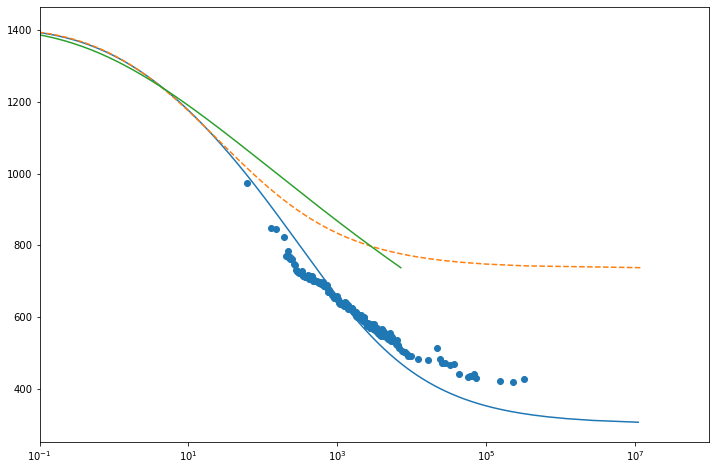

In [24]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

ax.plot(trange_earth, Trange)
# ax.plot(trange_venus_noconv[0], Trange, '--')
ax.plot(trange_venus_noconv[1], Trange, '--')
ax.plot(trange_venus_snyder, Trange)
# ax.scatter(t_data, T_data)
ax.scatter(t_Hon, Ts_Hon)
ax.semilogx()
ax.set_xlim(1e-1, 1e8)
plt.show()

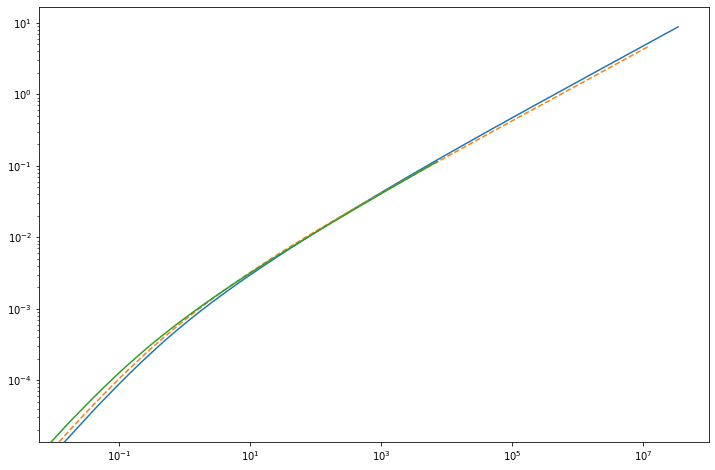

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

ax.plot(trange_earth, upper_crust_earth)
# ax.plot(trange_venus_noconv[0], upper_crust_venus_noconv[0], '--')
ax.plot(trange_venus_noconv[1], upper_crust_venus_noconv[1], '--')
ax.plot(trange_venus_snyder, upper_crust_venus_snyder)
# ax.scatter(t_data, T_data)
ax.semilogx()
ax.semilogy()
# ax.set_xlim(1e-1, 1e8)
plt.show()

### <b> Lava flow CAS model for a 10 m thick and 50m thick flow on Earth and Venus </b>

In [38]:
lava_thickness = [30, 50]

# Tlava = 1135 + 273
Tlava = 1200               ## assuming a lava flow starting at 1400 K has cooled by 200 K before stopping
Ta_venus = 737 
Ta_earth = 30 + 273
Tsub_venus = Ta_venus
Tsub_earth = Ta_earth

# ## Thermal parameters
# L = 3.2e5                 ## latent heat of fusion in J/kg; value from Wittmann et al.2017
# k = 1
# kappa = 5e-7

## Other variables
L = 100e3                    ## latent heat capacity in J/kg; value from Wittmann et al.2017
c =  1200                    ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 1                        ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
rho = 2600                   ## Basalt density from Davies et al., 2006
kappa = k/rho/c              ## thermal diffusivity in m2/s;

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

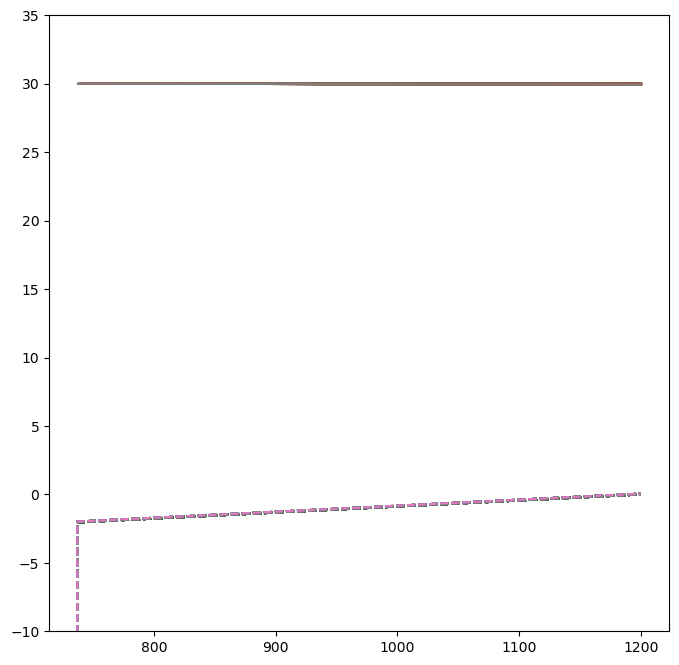

0.928436498267081


In [37]:
## Case 1 - Venus 10 m
prefile = "preSolid10m.pkl"
sfile = "Solid10m.pkl"
postfile = "postSolid10m.pkl"

lt = lava_thickness[0]
zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)
dt = 10

Tsub = Tsub_venus
Ta = Ta_venus 

T_pre_eq = np.arange(Tlava-1, Tsub, -0.5)
t_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
t_eq = 0
Cup_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
Cbase_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

T_up = np.zeros((len(T_pre_eq), ), dtype=np.float32)

t_surface_eq = 0
l_lower = 0
l_upper = 0

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

for i, T in enumerate(T_pre_eq):
    c = Lava.heat_capacity(T)
    rho = Lava.density(T)
    kappa = Lava.diffusivity(1, rho, c)
    
    ################### Computation of lambda ###########################################
    # Upper crust
    RHS = L * np.pi ** 0.5 / c / (Tlava - T)
    l_up = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))] 
    # Lower crust
    RHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)         
    l_base = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_basal_crust(lambdas)))] 
    
    
    ################### Computation of fluxes and time ###################################
    Qsnyder = Lava.Snyder_flux(T)
    # Qrad = Lava.Radiation_flux(T, Ta)
    # Qconv = Lava.Convection_flux(T, Ta)
    Q = Qsnyder
    # Q = Qrad + Qconv
    t = Lava.getTime(T, Tlava, Q, l_up, k, kappa)
    t_pre_eq[i] = t
    t_eq = t
    
    ################### Computation of fluxes and time ###################################
    Cbase_pre_eq[i] = Lava.crust_thickness(l_base, kappa, t)
    Cup_pre_eq[i] = Lava.crust_thickness(l_up, kappa, t)
   
    ################### Check if the lava hassolidified ##################################
    if Cup_pre_eq[i] + Cbase_pre_eq[i] >= lt:
        print("lava solidification occured at or before ", t/3600, " hours")
        break
        

    ################### Computtemperature profile in the basal crust #######################
    y_base = np.linspace(zend, Cbase_pre_eq[i], 50)
    T_base = (((Tlava-Tsub) / (erf(l_base)+1)) * (1 + erf(y_base / 2/ (kappa*t)**0.5))) + Tsub
       
    ################### Computtemperature profile in the upper crust #######################
    y_up = np.linspace(0, Cup_pre_eq[i], 50)
    T_up = (((Tlava-T) / erf(l_up)) * erf((y_up) / 2/(kappa*t)**0.5)) + T

    

    ax.plot(T_base, y_base, "--")
    ax.plot(T_up, lt-y_up)
    
    
    

    
plt.ylim(-10, lt+5)
plt.show()
print(t_eq/3600)

In [39]:
### trying a differnet algorithm
## Case 1 - Venus 10 m
prefile = "preSolid30m.pkl"
sfile = "Solid30m.pkl"
postfile = "postSolid30m.pkl"

## Case 1 - Venus 10 m
lt = lava_thickness[0]
zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)
dt = 10

Tsub = Tsub_venus
Ta = Ta_venus 

T_pre_eq = np.arange(Tlava-1, Tsub, -0.5)
t_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
l_up_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
l_base_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

t_eq = 0.0

t_solid_near = 0.0
t_solid = 0.0

C_up_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
C_base_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

T_up = np.zeros((len(T_pre_eq), ), dtype=np.float32)


for i, T in enumerate(T_pre_eq):
    # c = Lava.heat_capacity(T)
    # rho = Lava.density(T)
#     kappa = Lava.diffusivity(1, rho, c)
    
    ################### Computation of lambda ###########################################
    # Upper crust
    RHS = L * np.pi ** 0.5 / c / (Tlava - T)
    l_up_pre_eq[i] = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))] 
    # Lower crust
    RHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)         
    l_base_pre_eq[i] = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_basal_crust(lambdas)))] 
    
    
    ################### Computation of fluxes and time ###################################
    Qsnyder = Lava.Snyder_flux(T)
    # Qrad = Lava.Radiation_flux(T, Ta)
    # Qconv = Lava.Convection_flux(T, Ta)
    Q = Qsnyder
    # Q = Qrad + /Qconv
    t = Lava.getTime(T, Tlava, Q, l_up_pre_eq[i], k, kappa)
    t_pre_eq[i] = t
    t_eq = t
    
    ################### Computation of fluxes and time ###################################
    C_base_pre_eq[i] = Lava.crust_thickness(l_base_pre_eq[i], kappa, t)
    C_up_pre_eq[i] = Lava.crust_thickness(l_up_pre_eq[i], kappa, t)
    

   
    ################### Check if the lava has solidified ##################################
    if C_up_pre_eq[i] + C_base_pre_eq[i] >= lt:
        if t_solid_near == 0.0:
            t_solid_near = t
            T_solid_near = T
            print("upper_crust_thickness =", C_up_pre_eq[i])
            print("basal_crust_thickness =", C_base_pre_eq[i])
            print("lava solidification occured at or before ", t/3600, " hours")
            
print("surface equilibration to ambient temperature occured at ", t_eq, " seconds")

surface equilibration to ambient temperature occured at  3677.0350608791077  seconds


In [40]:
## Find time of solidification if lava has already solidified
delt = 10
print(lt)

if t_solid_near != 0.0:
    print("Lava has alrteady solidified. Finding time of solidification....")
    idx = np.where(t_pre_eq == t_solid_near)[0][0]
    tstart = t_pre_eq[idx-1]
    tstop = t_pre_eq[idx]
    Tsurf_solid = T_pre_eq[idx]
    
    interval = np.arange(tstart, tstop+delt, delt) 
    
    l_up_start = l_up_pre_eq[idx-1]
    l_up_stop = l_up_pre_eq[idx]
    del_l_up = (l_up_start - l_up_stop) / len(interval)
    
    l_base_start = l_base_pre_eq[idx-1]
    l_base_stop = l_base_pre_eq[idx]
    del_l_base = (l_base_start - l_base_stop) / len(interval)
    
    for i in range(len(interval)):
        t = interval[i]
        l_up = l_up_start + i*del_l_up
        l_base = l_base_start + i*del_l_base
        
        C_base= Lava.crust_thickness(l_base, kappa, interval[i])
        C_up = Lava.crust_thickness(l_up, kappa, interval[i])       
        if C_up + C_base > lt:
            print("upper_crust_thickness =", C_up)
            print("basal_crust_thickness =", C_base)
            print("Total crust thickness of ", C_up + C_base, " m was attained at time t = ", t_solid, " s")
            break  
            
        C_base_solid = C_base
        C_up_solid = C_up
        l_up_solid = l_up
        l_base_solid = l_base
        t_solid = interval[i]

elif t_solid_near == 0.0:
    print("Lava still not completely solid. Running forward in time to find point of solidification")
    l_up = l_up_pre_eq[-1]
    l_base = l_base_pre_eq[-1]
    l_up_solid = l_up
    l_base_solid = l_base
    Tsurf_solid = Ta
    
    
    t_post_eq = np.arange(t_eq+10, t_eq + 20*3.1536e7, 10)
    C_up_post_eq = np.zeros_like(t_post_eq, dtype = np.float32)
    C_base_post_eq = np.zeros_like(t_post_eq, dtype = np.float32)
    
    for i in range(len(t_post_eq)):
        C_base_post_eq[i] = Lava.crust_thickness(l_base, kappa, t_post_eq[i])
        C_up_post_eq[i] = Lava.crust_thickness(l_up, kappa, t_post_eq[i])
        
        if C_base_post_eq[i] + C_up_post_eq[i] > lt:
            print("upper_crust_thickness =", C_up_post_eq[i])
            print("basal_crust_thickness =", C_base_post_eq[i])
            print("Total crust thickness of ", C_base_post_eq[i] + C_up_post_eq[i], " m was attained at time t = ", t_solid, " s")
            break   
            
        C_base_solid = C_base_post_eq[i]
        C_up_solid = C_up_post_eq[i]
        t_solid = t_post_eq[i]

30
Lava still not completely solid. Running forward in time to find point of solidification
upper_crust_thickness = 16.82553
basal_crust_thickness = 13.174473
Total crust thickness of  30.000002  m was attained at time t =  185990137.03506088  s


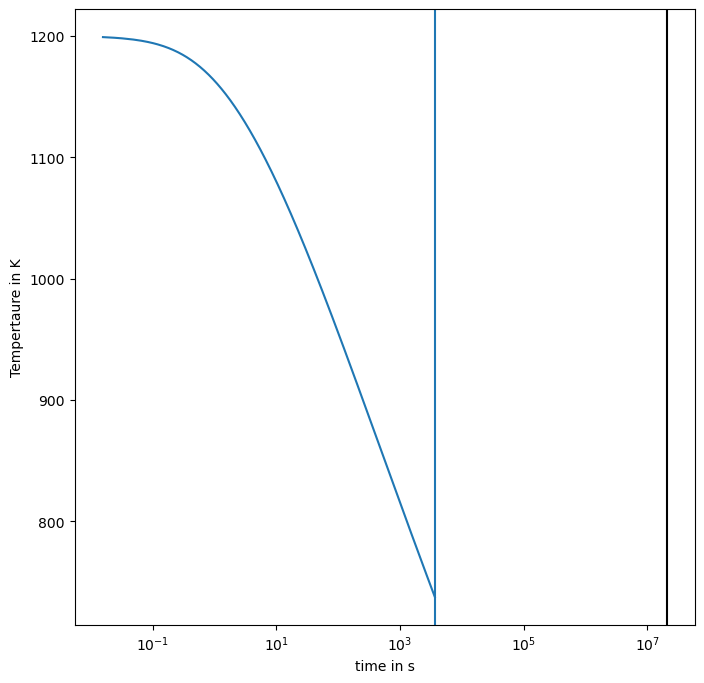

In [5]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

ax.plot(t_pre_eq, T_pre_eq)
ax.axvline(t_eq)
ax.axvline(t_solid_near, color = 'k', linestyle='--')
ax.axvline(t_solid, color = 'k')
ax.semilogx()

ax.set_xlabel("time in s")
ax.set_ylabel("Tempertaure in K")
plt.show()

In [47]:
print(t_solid/24/3600)

2152.6636230909826


In [42]:
# Temperature profiles of interest since eruption: 1 hour, 1 day, 1 week, 1 month, 1 year, 5 years, 10 years, and time of solidifcation
# times = [24*3600, 7*24*3600, 30*24*3600, 90*24*3600, 365*24*3600, 2*365*24*3600, 5*365*24*3600, 10*365*24*3600]
times = [24*3600, 7*24*3600, 30*24*3600, 365*24*3600, 10*365*24*3600, 20*365*24*3600, 25*365*24*3600, 50*365*24*3600]
# times.sort()
times = np.array(times)
# times = np.array(times.sort())

In [43]:
try:
    t_lookup = np.concatenate((t_pre_eq, t_post_eq))
    C_base_lookup = np.concatenate((C_base_pre_eq, C_base_post_eq))
    C_up_lookup = np.concatenate((C_up_pre_eq, C_up_post_eq))
    l_up_lookup = np.concatenate((l_up_pre_eq, l_up_pre_eq[-1] * np.ones_like(t_post_eq)))
    l_base_lookup = np.concatenate((l_base_pre_eq, l_base_pre_eq[-1] * np.ones_like(t_post_eq)))
    Tsurf_lookup = np.concatenate((T_pre_eq, Ta * np.ones_like(t_post_eq)))
    print("solidification occured after surface equilibration")
except:
    t_lookup = t_pre_eq
    l_up_lookup = l_up_pre_eq
    l_base_lookup = l_base_pre_eq
    C_up_lookup = C_up_pre_eq
    C_base_lookup = C_base_pre_eq
    Tsurf_lookup = T_pre_eq
    print("solidification occured before surface equilibration")

presolid_idx = []
for i in range(len(times)):
    if times[i] <= t_solid:
        a = np.abs(times[i] - t_lookup).argmin()
        presolid_idx.append(a)

solidification occured after surface equilibration


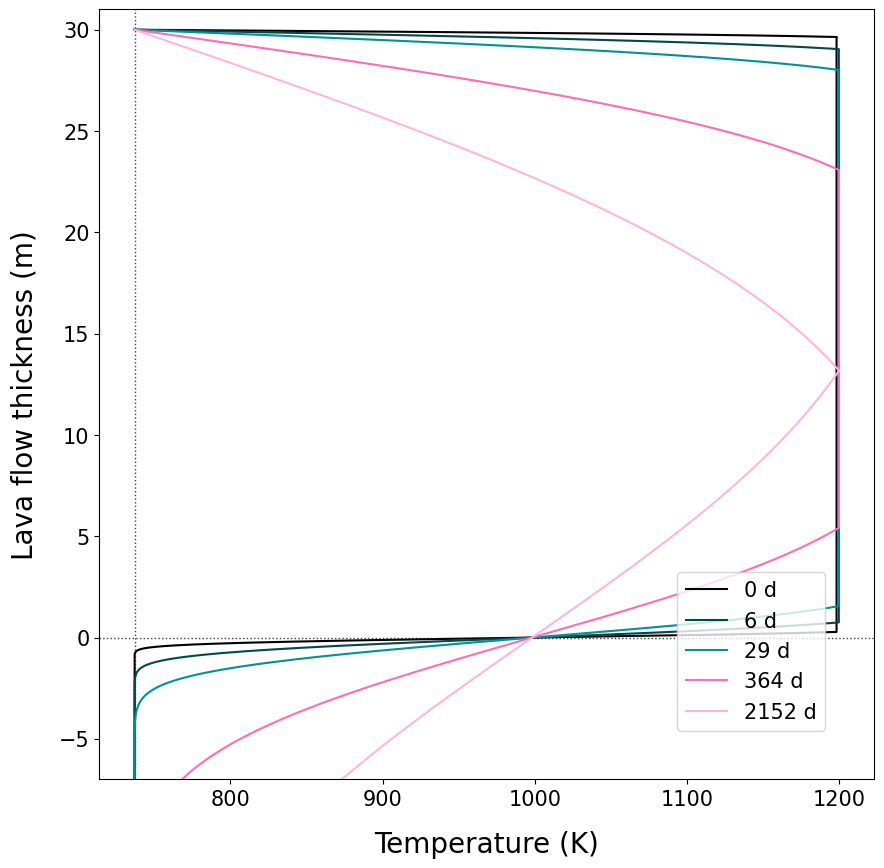

In [44]:
## Pre-solidification temperature calculation
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)

ax.axhline(0, linestyle = ":", linewidth = 1, color = "#404040")
# ax.axhline(lt/2, linestyle = ":", linewidth = 1, color = "#404040")
ax.axvline(Ta, linestyle = ":", linewidth = 1, color = "#404040")
# ax.axvline(Tlava, linestyle = ":", linewidth = 1, color = "#404040")
colors = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]
# colors = ["#fee391",  "#fec44f", "#fe9929", "#ec7014", "#cc4c02", "#8c2d04"]
# colors = ["#d0d1e6", "#a6bddb", "#67a9cf", "#3690c0", "#02818a", "#016450"]
color_idx = 0

zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)

        
T_preSC_up = []
T_preSC_base = []
        
z_preSC_up = []
z_preSC_base = []

T_preSC_all = []
z_preSC_all = []

for i in presolid_idx:
    t = t_lookup[i]
    C_up = C_up_lookup[i]
    C_base = C_base_lookup[i]
    l_up = l_up_lookup[i]
    l_base = l_base_lookup[i]
    Tsurf = Tsurf_lookup[i]
    
    ################### Compute temperature profile in the basal crust #######################
    y_base = np.arange(-100, C_base, dz)
    T_base = (((Tlava-Tsub) / (erf(l_base)+1)) * (1 + erf(y_base / 2/ (kappa*t)**0.5))) + Tsub
    T_preSC_base.append(T_base)
    z_preSC_base.append(y_base)
    
    ################### Compute temperature profile in the upper crust #######################
    y_up = np.arange(0, C_up, dz)
    T_up = (((Tlava-Tsurf) / erf(l_up)) * erf((y_up) / 2/(kappa*t)**0.5)) + Tsurf 
    T_preSC_up.append(T_up)
    z_preSC_up.append(lt-y_up)
    
    ################### Compute uniform temperature in the middle ############################
    z_base = y_base
    z_up = lt-y_up
    z_mid = np.arange(z_base[-1]+dz, z_up[-1], dz)
    T_mid = np.ones_like(z_mid) * T_base[-1]
    z_presolid = np.concatenate((z_base, z_mid, np.flip(z_up)))
    T_presolid = np.concatenate((T_base, T_mid, np.flip(T_up)))
    T_preSC_all.append(T_presolid)
    z_preSC_all.append(z_presolid)
#     y_mid = np.arange(y_base[-1]+dz, lt-y_up[-1], dz)
#     T_mid = np.ones_like(y_mid) * T_base[-1]
#     y_presolid = np.concatenate((y_base, y_mid, np.flip(lt-y_up)))
# #     z_preSC = z_preSC - lt
#     T_presolid = np.concatenate((T_base, T_mid, np.flip(T_up)))
    
#     T_preSC.append(T_presolid)
#     z_preSC.append(y_presolid)
    ax.plot(T_presolid, z_presolid , linewidth = 1.5, color = colors[color_idx], label = str(int(t/3600/24)) + " d")
    
    
#     ax.plot(T_base, y_base, "--", color = colors[color_idx], label = t/3600)
#     ax.plot(T_up, lt-y_up, color = colors[color_idx])
    color_idx += 1
    
with open(prefile, mode="wb") as f:
    pickle.dump([z_preSC_all, T_preSC_all], f)
        
        
################### Compute temperature profile at the time of solidification #######################
y_base_solid = np.arange(-100, C_base_solid, dz)
T_base_solid = (((Tlava-Tsub) / (erf(l_base_solid)+1)) * (1 + erf(y_base_solid / 2/ (kappa*t_solid)**0.5))) + Tsub

y_up_solid = np.arange(0, C_up_solid, dz)
T_up_solid = (((Tlava-Tsurf_solid) / erf(l_up_solid)) * erf((y_up_solid) / 2/(kappa*t_solid)**0.5)) + Tsurf_solid 

ax.plot(T_base_solid, y_base_solid, linewidth = 1.5, color = colors[color_idx], label = str(int(t_solid/3600/24)) + " d")
ax.plot(T_up_solid, lt-y_up_solid, linewidth = 1.5, color = colors[color_idx])
 
# ax.axvline(Tlava, color='k')   
# ax.axhline(lt/2, linestyle = ":", linewidth = 1, color = "#404040")
ax.set_ylim(-7, lt+1)

ax.set_xlabel("Temperature (K)", fontsize=20, labelpad=15)
ax.set_ylabel("Lava flow thickness (m)", fontsize=20, labelpad=15)
    
ax.legend(loc = "lower right", bbox_to_anchor=(0.95, 0.05), fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.legend(fontsize = 14)
# plt.savefig("presolidification_dTdz_1m.png")
plt.show()

plt.show()

In [45]:
## Post-solidification temperature profile calculation

postsolid_times = times[times > t_solid].astype(float)
print(postsolid_times)


dt = 10                                                    ## delta_t in seconds
time_total = times[-1] + dt
# t_range = np.arange(time_solid, time_total+dt, dt).astype(np.float32)

## Initial_condition
t = t_solid
z_SC = np.concatenate((y_base_solid, np.flip(lt-y_up_solid)), axis = 0)          ## join together lower crust z and upper crust z
T_SC = np.concatenate((T_base_solid, np.flip(T_up_solid)), axis = 0)          ## join together lower crust T and upper crust T

with open(sfile, mode="wb") as f:
    pickle.dump([z_SC, T_SC], f)

## Note 1: Upper crust measuremnts are z downwards, so they need to be flipped 
## Note 2: The soldification point (z, T) are present in both the lower crust array and the upper crust array; removing the common (z, T) upper crust array.

# m = 10
# dprint = (time_total - t_solid) / m
# printat = t_solid + dprint

T_postSC = np.zeros((len(postsolid_times), len(z_SC)), dtype=np.float32)
# T_postSC = np.zeros((len(postsolid_times), len(z_range)), dtype=np.float32)

[3.1536e+08 6.3072e+08 7.8840e+08 1.5768e+09]


0 -2.9649391174316406 315359997.0350609 315360000.0
1 -2.9649391174316406 630719997.0350609 630720000.0
2 -2.9649391174316406 788399997.0350609 788400000.0
3 -2.9649391174316406 1576799997.035061 1576800000.0


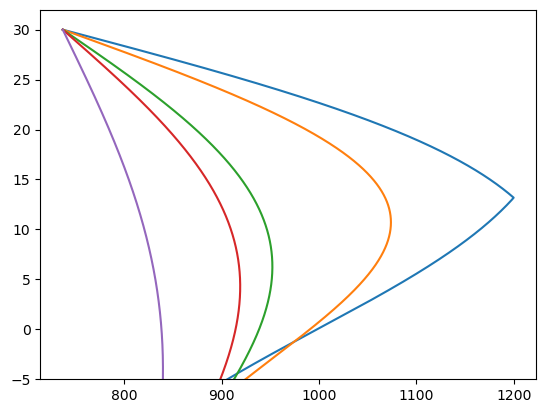

In [46]:
plt.figure()

T_n = T_SC
plt.plot(T_n, z_SC)

idx = 0
while t <= time_total:
    
    T_nplus = T_n + ( 
                    (kappa*dt/dz**2) * np.diff(T_n, n=2, prepend = T_n[0], append=T_n[-1]) 
                  )   
   
    t+=dt
    ################ check whether to store output at exactly the required time - needs dt = 1 s ################
    # if t in postsolid_times:
    #     print(idx, t)
    #     T_postSC[idx, :] = T_nplus
    #     idx += 1
    #     plt.plot(T_nplus, z_SC)
    ##############################################################################################################
    
    
    ########## check whether to store output at at time closest to the times of interest after solidification ####
    if np.abs(t-postsolid_times[idx])<10:
        print(idx, t-postsolid_times[idx], t, postsolid_times[idx])
        T_postSC[idx, :] = T_nplus
        idx += 1
        plt.plot(T_nplus, z_SC)
    ##############################################################################################################
        
    
    # ################# check whether to store output at random times equally dispersed in time #################
    # if t >= printat:
    #     print(idx)
    #     T_postSC[idx, :] = T_nplus
    #     printat += dprint
    #     idx += 1
    #     plt.plot(T_nplus, z_SC)
    #############################################################################################################
        
    # Break if results for all times of interest after solidicfication have been stored
    if idx == len(postsolid_times):
            break
        
        
    # Update boundary_conditions

    T_nplus[-1] = Tsub    
    T_nplus[0] = Tsub
    
    
    # variables for next step
    T_n = T_nplus
    
    
plt.ylim(-5, lt + 2)
plt.show()   

with open(postfile, mode="wb") as f:
    pickle.dump([z_SC, T_postSC], f)

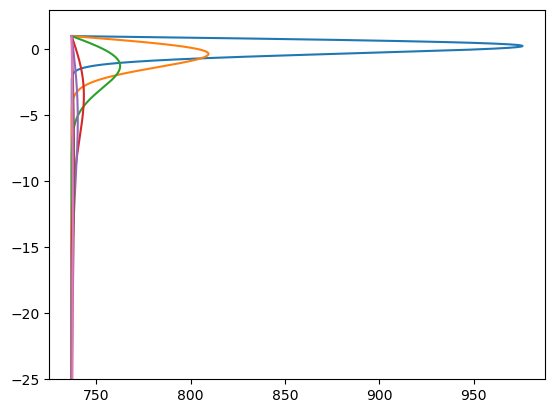

In [29]:
plt.figure()
for i in range(len(postsolid_times)):
    plt.plot(T_postSC[i], z_SC)
    
plt.ylim(-25, lt + 2)
plt.show()

In [14]:
## Effective temperature from integration of subsurface temperature

### EM properties
# thi_rad = np.deg2rad([45])
thi_rad = np.linspace(np.deg2rad(0), np.deg2rad(80), 20)
wv = 9.6e-2
eps1 = 5 + 0.01j
tand1 = eps1.imag / eps1.real
alpha = (2 * np.pi / wv) * np.sqrt(0.5*eps1.real * (np.sqrt(1 + tand1**2) - 1))
ka = 2 * alpha
beta = ka / np.cos(thi_rad)


num =  len(T_preSC_all) + len(postsolid_times) + 1

## before solidification
T_preSC_eff = []
for i in range(len(T_preSC_all)):
    
    #############################################working code#########################################
#     z_base = z_preSC_base[i]
#     z_up = z_preSC_up[i]
#     T_base = T_preSC_base[i]
#     T_up = T_preSC_up[i]
#     z_mid = np.arange(z_base[-1]+dz, z_up[-1], dz)
#     T_mid = np.ones_like(z_mid) * T_base[-1]
#     z_preSC = np.concatenate((z_base, z_mid, np.flip(z_up)))
#     z_preSC = z_preSC - lt
#     T_preSC = np.concatenate((T_base, T_mid, np.flip(T_up)))
    
#     T_preSC_eff_single = np.zeros(len(thi_rad), dtype = float)
#     for j in range(len(thi_rad)):
#         func = beta[j] * np.exp(beta[j] * z_preSC) * T_preSC
#         T_preSC_eff_single[j] = integrate.simpson(func, z_preSC)
#         T_preSC_eff.append(T_preSC_eff_single)
    ###################################################################################################### 
    
    ############ computing effective temperature from what is stored earlier in T_preSC_all and z_preSC_all################
    z_preSC_single = z_preSC_all[i] - lt
    T_preSC_eff_single = np.zeros(len(thi_rad), dtype = float)
    for j in range(len(thi_rad)):
        func = beta[j] * np.exp(beta[j] * z_preSC_single) * T_preSC_all[i]
        T_preSC_eff_single[j] = integrate.simpson(func, z_preSC_single)
    T_preSC_eff.append(T_preSC_eff_single)
    ###########################################################################################################
    
## at the point of solidification
z_SC_downward = z_SC - lt               ### making top of lava surface as z = 0
T_SC_eff = np.zeros((len(thi_rad)), dtype=float)
for i in range(len(thi_rad)):
    func = beta[i] * np.exp(beta[i]* z_SC_downward) * T_SC 
    T_SC_eff[i] = integrate.simpson(func, z_SC_downward)

    
### after solidifcation
T_postSC_eff = np.zeros((len(thi_rad), len(postsolid_times)), dtype=float)

for i in range(len(thi_rad)):
    for j in range(len(postsolid_times)):
        # print(T_postSC[j])
        func = beta[i] * np.exp(beta[i] * z_SC_downward) * T_postSC[j]
        T_postSC_eff[i,j] = integrate.simpson(func, z_SC_downward)

IndexError: index 2 is out of bounds for axis 1 with size 2

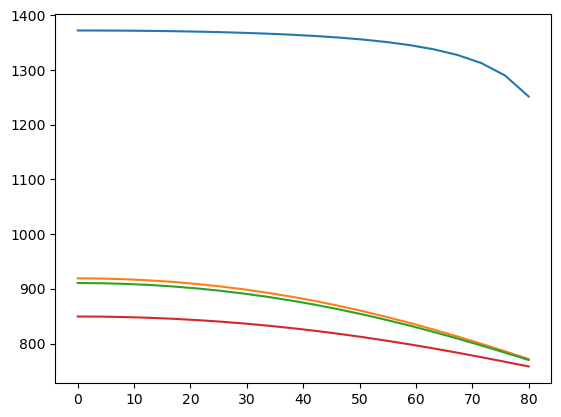

In [15]:
plt.figure()
plt.plot(np.rad2deg(thi_rad), T_preSC_eff[0])
plt.plot(np.rad2deg(thi_rad), T_SC_eff)
plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,0])
plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,1])
plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,2])
plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,3])
# plt.plot(np.rad2deg(thi_rad), T_postSC_eff[:,4])

plt.show()

### <b> Make plots from stored temperature profiles <b>

In [2]:
# # t_solid_1m = 1.6640608468132772e+05
# t_solid_1m = 157524.52839880463
# t_solid_10m = 15752734.528398804 
# t_solid_50m = 416020506.08468133
# t_solid_30m = 141774704.5283988

In [30]:
t_solid_1m = 206647.0350608791
t_solid_10m = 20665567.03506088
t_solid_50m = 516639277.0350609
t_solid_30m = 185990137.03506088

In [31]:
Ta = Ta_venus
# Tlava = 1135 + 273
lavaheight = 30
time_of_solid = t_solid_30m
sfile = "Solid30m.pkl" #"./backup_pkl/Solid10m.pkl"
prefile = "preSolid30m.pkl" #"./backup_pkl/preSolid10m.pkl"
postfile = "postSolid30m.pkl"  #"./backup_pkl/postSolid10m.pkl"

with open (sfile, mode = "rb") as f:
    solid = pickle.load(f)
with open (prefile, mode = "rb") as g:
    pre = pickle.load(g)
with open (postfile, mode = "rb") as h:
    post = pickle.load(h)

In [32]:
depth_solid = solid[0]
temp_solid = solid[1]

depths_pre = pre[0]
temps_pre = pre[1]

depth_post = post[0]
temps_post = post[1]

In [33]:
times = [24*3600, 7*24*3600, 30*24*3600, 90*24*3600, 365*24*3600, 2*365*24*3600, 5*365*24*3600, 10*365*24*3600]
# times = [24*3600, 7*24*3600, 30*24*3600, 365*24*3600, 10*365*24*3600, 20*365*24*3600, 25*365*24*3600, 50*365*24*3600]
times = np.array(times)
sidx = np.where(time_of_solid > times)[0][-1] + 1
print(sidx)

1


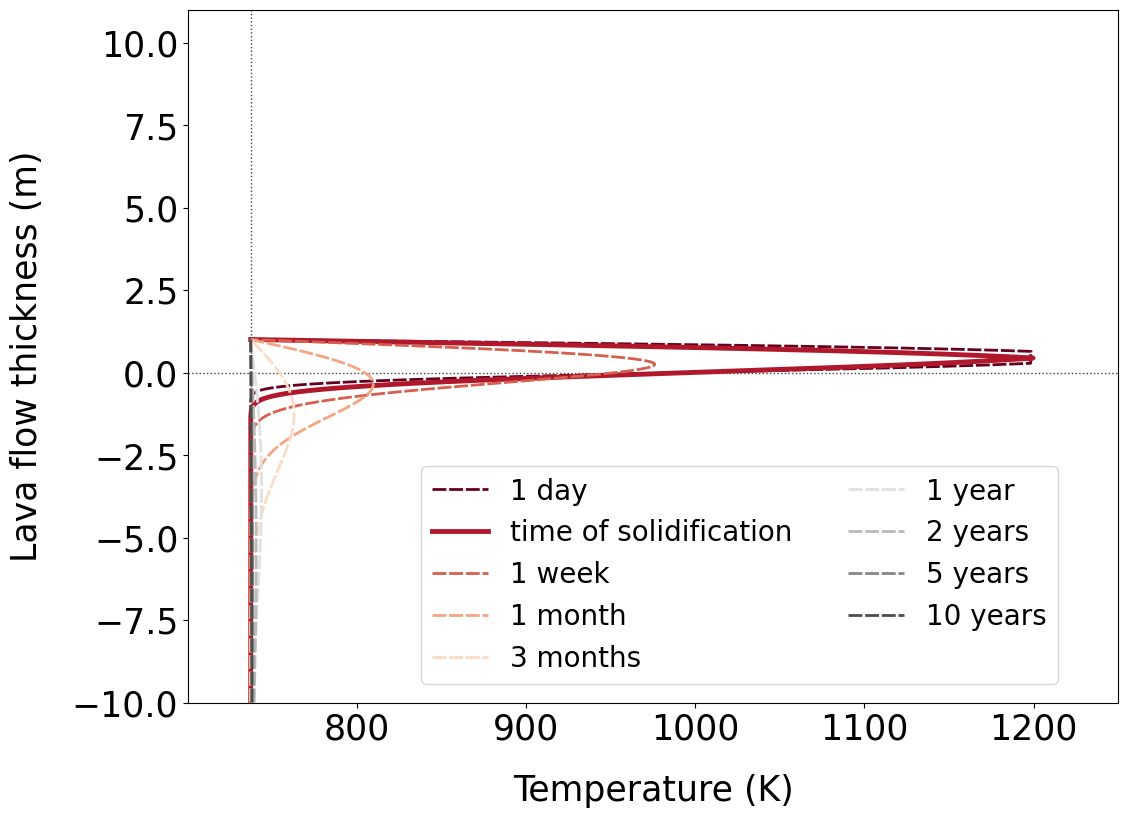

In [35]:

## Pre-solidification temperature profile
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 9)

ax.axhline(0, linestyle = ":", linewidth = 1, color = "#404040")
ax.axvline(Ta, linestyle = ":", linewidth = 1, color = "#404040")

labels = ["1 day", "1 week", "1 month", "3 months", "1 year", "2 years", "5 years", "10 years"]
# labels = ["1 day", "1 week", "1 month", "1 year", "10 years", "20 years", "25 years", "50 years"]
labels.insert(sidx, "time of solidification")

# colors = ["#d0d1e6", "#a6bddb", "#67a9cf", "#3690c0", "#02818a", "#016450"]
colors = ["#67001f", "#b2182b","#d6604d", "#f4a582", "#fddbc7", "#e0e0e0", "#bababa", "#878787", "#4d4d4d", "#1a1a1a"]
# colors = ["#a50026", "#d73027", "#f46d43", "#fdae61", "#fee090", "#e0f3f8", "#abd9e9", "#74add1", "#4575b4", "#313695"]
color_idx = 0
label_idx = 0

for i in range(len(depths_pre)):
    ax.plot(temps_pre[i], depths_pre[i] , linewidth = 2, color = colors[color_idx], linestyle=(0, (5,1)),  label = labels[label_idx]) #str(int(times[color_idx]/3600/24)) + " d")
    color_idx += 1
    label_idx += 1
    
ax.plot(temp_solid, depth_solid , linewidth = 3.5, color = colors[color_idx], label = labels[label_idx])#,label = str(int(t_solid/3600/24)) + " d")
color_idx += 1
label_idx += 1


for i in range(len(temps_post)):
    ax.plot(temps_post[i], depth_post , linewidth = 2, color = colors[color_idx], linestyle = (0, (5,1)), label = labels[label_idx]) #str(int(times[color_idx-1]/3600/24)) + " d")
    color_idx += 1
    label_idx += 1
    
ax.set_ylim(-10, 31)
ax.set_xlim(700, Tlava+50)

ax.set_xlabel("Temperature (K)", fontsize=25, labelpad=20)
ax.set_ylabel("Lava flow thickness (m)", fontsize=25, labelpad=20)
    
ax.legend(loc = "lower right", bbox_to_anchor=(0.95, 0.007), fontsize = 20, ncol = 2)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
# plt.legend(fontsize = 14)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis= 'x', nbins=6)
# plt.savefig("dTdz_10m_Jan5.tif", bbox_inches='tight')
plt.show()

In [7]:
lt = lavaheight
### EM properties
# thi_rad = np.deg2rad([45])
thi_rad = np.linspace(np.deg2rad(0), np.deg2rad(80), 20)
wv = 9.5e-2
eps0 = 1 + 0.00j
eps1 = 5 + 0.05j
tand1 = eps1.imag / eps1.real
alpha = (2 * np.pi / wv) * np.sqrt(0.5*eps1.real * (np.sqrt(1 + tand1**2) - 1))
ka = 2 * alpha
beta = ka / np.cos(thi_rad)
print(tand1, ka, 1/ka)

T_eff_all = []

## brightness temperature before solidification
T_preSC_eff = []
for i in range(len(temps_pre)):   
    ############ computing effective temperature from what is stored earlier in T_preSC_all and z_preSC_all################
    z_preSC_single = depths_pre[i] - lt
    T_preSC_eff_single = np.zeros(len(thi_rad), dtype = float)
    for j in range(len(thi_rad)):
        func = beta[j] * np.exp(beta[j] * z_preSC_single) * temps_pre[i]
        T_preSC_eff_single[j] = integrate.simpson(func, z_preSC_single)
    T_preSC_eff.append(T_preSC_eff_single)
    T_eff_all.append(T_preSC_eff_single)
    ###########################################################################################################
    
    
## at the point of solidification
z_SC_downward = depth_solid - lt               ### making top of lava surface as z = 0
T_SC_eff = np.zeros((len(thi_rad)), dtype=float)
for i in range(len(thi_rad)):
    func = beta[i] * np.exp(beta[i]* z_SC_downward) * temp_solid 
    T_SC_eff[i] = integrate.simpson(func, z_SC_downward)
T_eff_all.append(T_SC_eff)
    
### after solidifcation
T_postSC_eff = np.zeros((len(temps_post), len(thi_rad)), dtype=float)
z_postSC_downwards = depth_post - lt 
for i in range(len(temps_post)):
    for j in range(len(thi_rad)):
        # print(T_postSC[j])
        func = beta[j] * np.exp(beta[j] * z_postSC_downwards) * temps_post[i]
        T_postSC_eff[i,j] = integrate.simpson(func, z_postSC_downwards)
    T_eff_all.append(T_postSC_eff[i])

0.01 1.4788898788823306 0.676182868163077


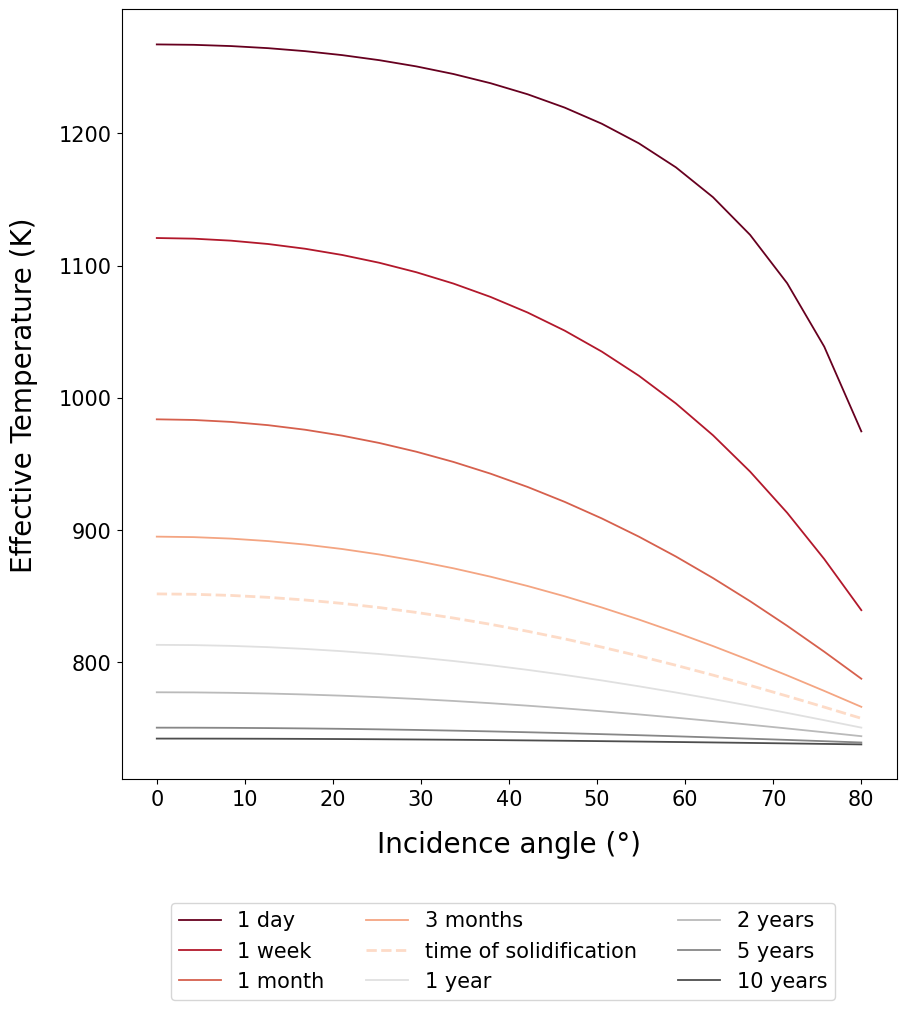

In [8]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)


for i in range(len(T_eff_all)):
    if i == sidx:
        ax.plot(np.rad2deg(thi_rad), T_eff_all[i], colors[i], linewidth = 2, label = labels[i], linestyle = "--")
    else:
        ax.plot(np.rad2deg(thi_rad), T_eff_all[i], colors[i], linewidth = 1.3, label = labels[i])

# # ax.set_xlim(0, 60)
# ax.set_ylim(700, Tlava+50)

ax.set_ylabel("Effective Temperature (K)", fontsize=20, labelpad=15)
ax.set_xlabel("Incidence angle (°)", fontsize=20, labelpad=15)
    
# ax.legend(loc = "lower right", bbox_to_anchor=(0.95, 0.05), fontsize = 15)
ax.legend(loc = "lower left", bbox_to_anchor= (0.05, -0.3), fontsize = 15, ncol = 3)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

/home/indujaa/anaconda3/envs/seis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


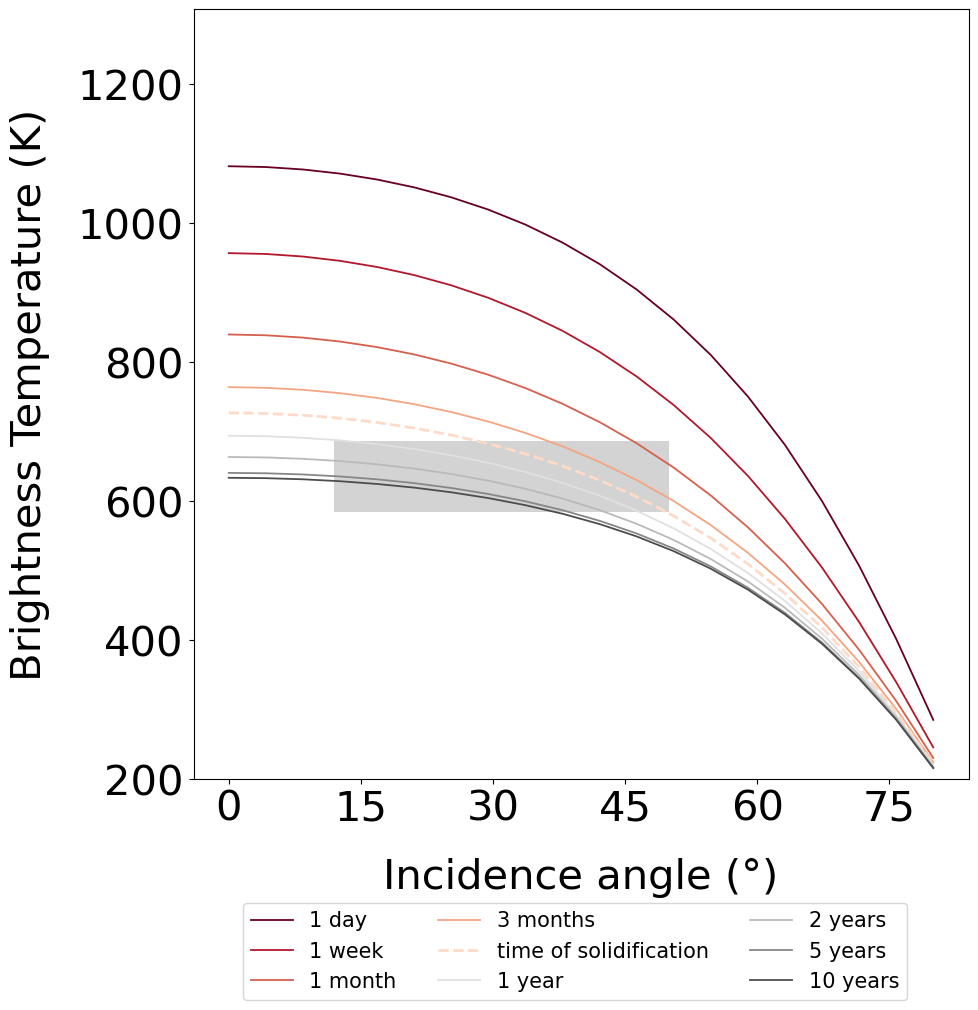

In [9]:
### Brightness temperature

rh, th, Rh, Th = FresnelH(eps0, eps1, thi_rad)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)

mag_thi = np.linspace(12, 50, 10)    
mag_tb_min = np.ones_like(mag_thi) * (635.4576 - 51.163)
mag_tb_max = np.ones_like(mag_thi) * (635.4576 + 51.163)

ax.fill_between(mag_thi, mag_tb_min, mag_tb_max, color = "#252525", edgecolor = None, alpha = 0.2)

for i in range(len(T_eff_all)):
    Tb = (1-Rh) * T_eff_all[i]
    
    if i == sidx:
        ax.plot(np.rad2deg(thi_rad), Tb, colors[i], linewidth = 2, linestyle = "--", label = labels[i])
    else:
        ax.plot(np.rad2deg(thi_rad), Tb, colors[i], linewidth = 1.3, label = labels[i])

# ax.set_xlim(0, 60)
ax.set_ylim(200, Tlava-100)

ax.set_ylabel("Brightness Temperature (K)", fontsize=30, labelpad=20)
ax.set_xlabel("Incidence angle (°)", fontsize=30, labelpad=20)
    
ax.legend(loc = "lower left", bbox_to_anchor= (0.05, -0.3), fontsize = 15, ncol = 3)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis= 'x', nbins=6)

# plt.savefig("Tb_10m_closeup.png", bbox_inches='tight')
plt.show()

[629.46263053+0.j 628.94206158+0.j 627.36633782+0.j 624.69288875+0.j
 620.84901624+0.j 615.72922267+0.j 609.19137269+0.j 601.05160114+0.j
 591.07787207+0.j 578.98210347+0.j 564.41080856+0.j 546.9342781 +0.j
 526.03445403+0.j 501.09183708+0.j 471.37204435+0.j 436.01299589+0.j
 394.01415877+0.j 344.22979103+0.j 285.36865737+0.j 216.00315234+0.j]


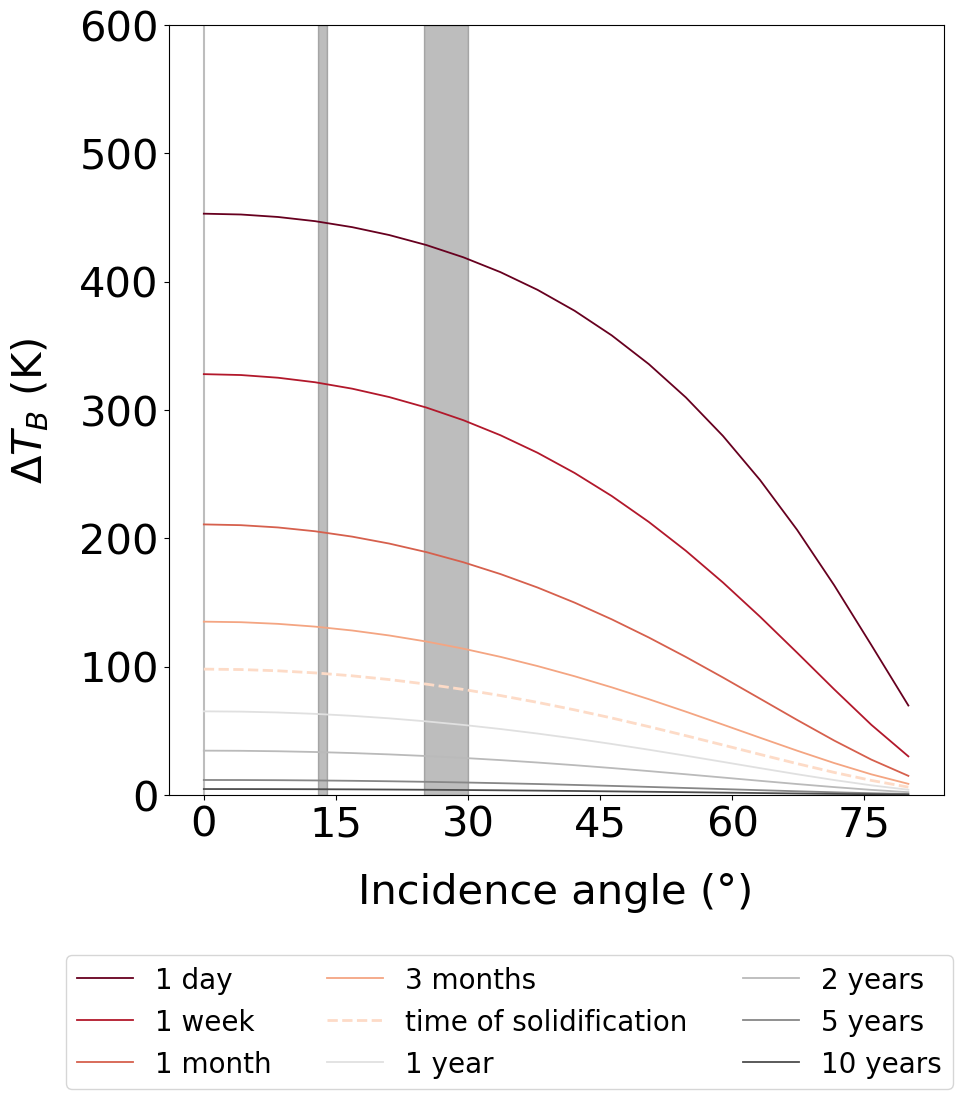

In [10]:
### Brightness temperature

rh, th, Rh, Th = FresnelH(eps0, eps1, thi_rad)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)

vensar_offnadir1 = 25
vensar_offnadir2 = 30

vensar_nearnadir1 =13
vensar_nearnadir2 = 14

ax.axvspan(vensar_offnadir1, vensar_offnadir2, alpha = 0.3, color = "#252525")
ax.axvspan(vensar_nearnadir1, vensar_nearnadir2, alpha = 0.3, color = "#252525")
ax.axvline(0, alpha = 0.3, color = "#252525")


# ax.axhline(635.4576 - 51.163, color = "k", linestyle = ":")
# ax.axhline(635.4576 + 51.163, color = "k", linestyle = ":")

# mag_thi = np.linspace(12, 50, 10)    
# mag_tb_min = np.ones_like(mag_thi) * (635.4576 - 51.163)
# mag_tb_max = np.ones_like(mag_thi) * (635.4576 + 51.163)
# ax.fill_between(mag_thi, mag_tb_min, mag_tb_max, color = None, edgecolor = "None", alpha = 0.4)

Tb_background = np.ones_like(thi_rad)*Ta*(1-Rh)
print(Tb_background)

for i in range(len(T_eff_all)):
    Tb = ((1-Rh) * T_eff_all[i]) - Tb_background 
    
    if i == sidx:
        ax.plot(np.rad2deg(thi_rad), Tb, colors[i], linewidth = 2, linestyle = "--", label = labels[i])
    else:
        ax.plot(np.rad2deg(thi_rad), Tb, colors[i], linewidth = 1.3, label = labels[i])

# ax.set_xlim(0, 60)
ax.set_ylim(0, 600)

ax.set_ylabel(r"$ \Delta T_{B} $ (K)", fontsize=30, labelpad=20)
ax.set_xlabel("Incidence angle (°)", fontsize=30, labelpad=20)
    
ax.legend(loc = "lower left", bbox_to_anchor= (-0.15, -0.4), fontsize = 20, ncol = 3)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis= 'x', nbins=6)

# plt.savefig("delTb_1m_tand005.png", bbox_inches='tight')
plt.show()

9


/home/indujaa/anaconda3/envs/seis/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


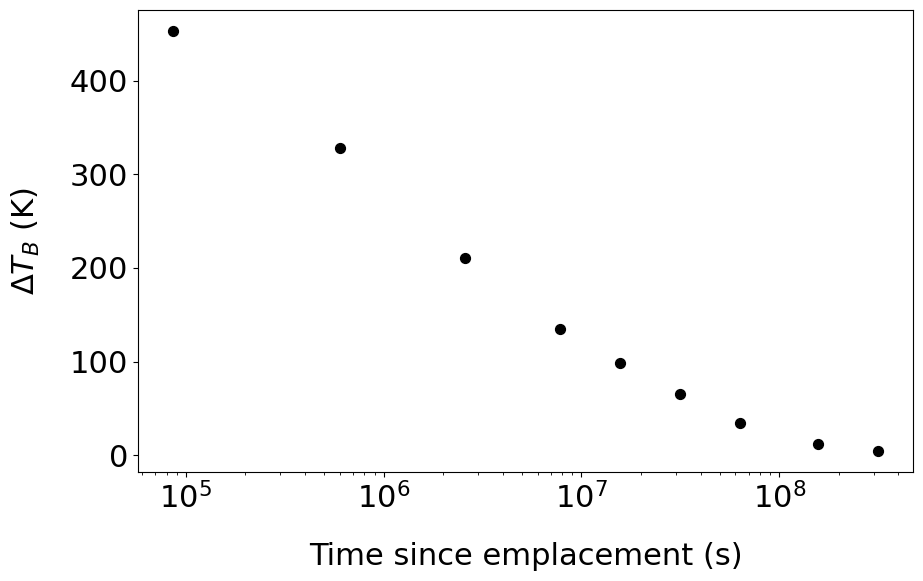

In [11]:
### nadir brightness temperature plots

rh, th, Rh, Th = FresnelH(eps0, eps1, thi_rad)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 6)

times_all = times.tolist()
times_all.insert(sidx, time_of_solid)
Tb_nadir_all = []

for i in range(len(T_eff_all)):
    Tb = ((1-Rh) * T_eff_all[i]) - Tb_background 
    Tb_nadir_all.append(Tb[0])

print(len(times_all))
ax.scatter(times_all, Tb_nadir_all, color = 'k', s=50)

# ax.set_xlim(0, 60)
# ax.set_ylim(0, 600)

ax.set_ylabel(r"$ \Delta T_{B} $ (K)", fontsize=22, labelpad=20)
ax.set_xlabel("Time since emplacement (s)", fontsize=22, labelpad=20)
    
# ax.legend(loc = "lower left", bbox_to_anchor= (-0.15, -0.4), fontsize = 20, ncol = 3)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis= 'x', nbins=6)

plt.semilogx()
# plt.savefig("TB_time_30m.tif", bbox_inches='tight')
plt.show()


In [12]:
t_array = np.array(times_all)
Tb_array = np.array(Tb_nadir_all)
arr = np.concatenate((t_array.reshape(1,-1), Tb_array.reshape(1,-1)), axis = 0)
np.savetxt("Tb_nadir_30m.csv", arr)

In [13]:
tb1 = np.genfromtxt("Tb_nadir_1m.csv", dtype = np.complex128)
tb10 = np.genfromtxt("Tb_nadir_10m.csv", dtype = np.complex128)
tb30 = np.genfromtxt("Tb_nadir_30m.csv", dtype = np.complex128)

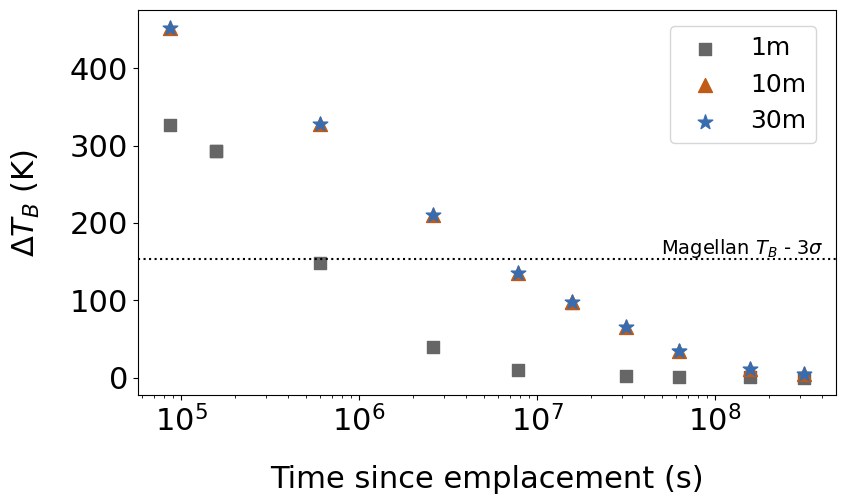

In [18]:
### nadir brightness temperature plots

rh, th, Rh, Th = FresnelH(eps0, eps1, thi_rad)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(9, 5)

times_all = times.tolist()
times_all.insert(sidx, time_of_solid)
Tb_nadir_all = []


#41b6c4


ax.scatter(tb1[0][1], tb1[1][1], s=70, marker = "s", c= "#666666")
ax.scatter(tb10[0][4], tb10[1][4], s=100, marker = "^", c = "#bf5b17")
ax.scatter(tb30[0][6], tb30[1][6], s=100, marker = "*", c= "#386cb0")

ax.scatter(tb1[0], tb1[1], s=70, marker = "s", c = "#666666", label = "1m")
ax.scatter(tb10[0], tb10[1], s=100, marker = "^", c = "#bf5b17", label = "10m")
ax.scatter(tb30[0], tb30[1], s=120, marker = "*", c = "#386cb0", label = "30m")

ax.axhline(153.48, color = 'k', linestyle = ":", linewidth = 1.5)


ax.set_ylabel(r"$ \Delta T_{B} $ (K)", fontsize=22, labelpad=20)
ax.set_xlabel("Time since emplacement (s)", fontsize=22, labelpad=20)

ax.text(0.75, 0.41, "Magellan "+r"$ T_{B} $" + " - 3" + r"$\sigma$", transform=ax.transAxes, fontsize=14, verticalalignment='top')
    
ax.legend(loc = "upper right", bbox_to_anchor= (0.99, 0.99), fontsize = 18, ncol = 1)

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis= 'x', nbins=6)

plt.semilogx()
plt.savefig("TB_time_all_3s_new.tif", bbox_inches='tight')
plt.show()

In [41]:
tb1[0,1]

(157524.52839880463+0j)